In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import sklearn
import statsmodels
import scipy
import xgboost
%matplotlib inline



# Library Version


print('pandas: %s' % pd.__version__)
print('numpy: %s' % np.__version__)
import matplotlib as mt
print('matplotlib: %s' % mt.__version__)
print('seaborn: %s' % sns.__version__)
print('sklearn: %s' % sklearn.__version__)
#print('imblearn: %s' % imblearn.__version__)
print('statmodels: %s' % statsmodels.__version__)
print('scipy: %s' % scipy.__version__)
print('XGBoost: %s' % xgboost.__version__)

pandas: 0.23.4
numpy: 1.18.5
matplotlib: 3.0.0
seaborn: 0.9.0
sklearn: 0.22.2.post1
statmodels: 0.9.0
scipy: 1.1.0
XGBoost: 1.1.1


C:\Users\Nandhu\miniconda3\envs\study\lib\site-packages\xgboost\__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [11]:
train=pd.read_csv('train.csv')

In [12]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
test=pd.read_csv('test.csv')

In [14]:
test['Survived']=np.nan

In [15]:
test=test[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']]

In [16]:
print('train dataset shape:{}, \ntest dataset shape: {}'.format(train.shape,test.shape))

train dataset shape:(891, 12), 
test dataset shape: (418, 12)


## Combining data

In [17]:
train.set_index('PassengerId',inplace=True)
test.set_index('PassengerId',inplace=True)

In [18]:
data=pd.concat([train,test])

In [19]:
data_copy=data.copy()
data_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Missing data handling

In [20]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Survived    891 non-null float64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


<h4>Missing data in Dataset</h4>

> * Column **'Age'** have **263** missing values,

> * Column **'Cabin'** have **1014 (77.46%)** missing values. We cant fill the missing values. Because column 'Cabin' indicates cabin number of passenger,

> * Column **'Fare'** have **1** missing values,

> * Column **'Embarked'** have **2** missing values.

<h3><b>AGE</b></h3>

Column **'Age'** is indicates ages of the passenger. so filling missing values with **mean()** is not an appropriate solution,
and it affects the distribution of the age in dataset. The solution sholdn't affect the distribution of ages. Then we have to calculate the **current distribution** ages from **present values (1046)**. Then scale that distribution to **entire dataset (1309)** by filling missing values.

In [21]:
# Calculating the Current distribution of ages(1046).

current_dist=data_copy['Age'].value_counts()#.head()


# Scaling the distribution to full dataset. In meantime, converting scaled distribution into missing distribution
# (scaled distribution [(x/1046)*1309+$] - present(x) )
# $ helps to build the perfect fitting missing distribution

missing_dist=current_dist.apply(lambda x:round(((x/1046)*1309)-x))

missing_dist.sum()


273

In [22]:
missing_dist_o_dict=OrderedDict(missing_dist)
missing_data_age_dict=dict(data_copy['Age'].isna())
#train['Age'].value_counts()

In [23]:
missing_dist_o_dict.items()

odict_items([(24.0, 12), (22.0, 11), (21.0, 10), (30.0, 10), (18.0, 10), (25.0, 9), (28.0, 8), (36.0, 8), (26.0, 8), (29.0, 8), (27.0, 8), (19.0, 7), (23.0, 7), (32.0, 6), (20.0, 6), (35.0, 6), (31.0, 6), (45.0, 5), (33.0, 5), (17.0, 5), (39.0, 5), (16.0, 5), (42.0, 5), (40.0, 5), (34.0, 4), (50.0, 4), (47.0, 4), (48.0, 4), (38.0, 4), (2.0, 3), (41.0, 3), (9.0, 3), (1.0, 3), (54.0, 3), (4.0, 3), (44.0, 3), (43.0, 2), (37.0, 2), (49.0, 2), (14.0, 2), (55.0, 2), (51.0, 2), (60.0, 2), (3.0, 2), (6.0, 2), (8.0, 2), (46.0, 2), (15.0, 2), (52.0, 2), (58.0, 2), (13.0, 1), (64.0, 1), (62.0, 1), (5.0, 1), (57.0, 1), (61.0, 1), (32.5, 1), (7.0, 1), (11.0, 1), (53.0, 1), (56.0, 1), (63.0, 1), (10.0, 1), (0.75, 1), (65.0, 1), (18.5, 1), (40.5, 1), (59.0, 1), (28.5, 1), (12.0, 1), (0.83, 1), (34.5, 1), (71.0, 1), (45.5, 1), (70.0, 1), (14.5, 1), (30.5, 1), (0.92, 1), (36.5, 1), (23.5, 0), (67.0, 0), (60.5, 0), (38.5, 0), (0.17, 0), (55.5, 0), (0.33, 0), (20.5, 0), (24.5, 0), (66.0, 0), (0.42, 0), (

In [24]:
try:
    z=[]
    for i,j in missing_data_age_dict.items():
        if j:
            z.append(i)
    k=0
    for i,j in missing_dist_o_dict.items():
        count=0
        while j>count:
            data_copy['Age'][z[k]]=i
            k+=1
            count+=1
except IndexError:
    pass


C:\Users\Nandhu\miniconda3\envs\study\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [25]:
data_copy['Age'].isna().sum()

0

C:\Users\Nandhu\miniconda3\envs\study\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Nandhu\miniconda3\envs\study\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


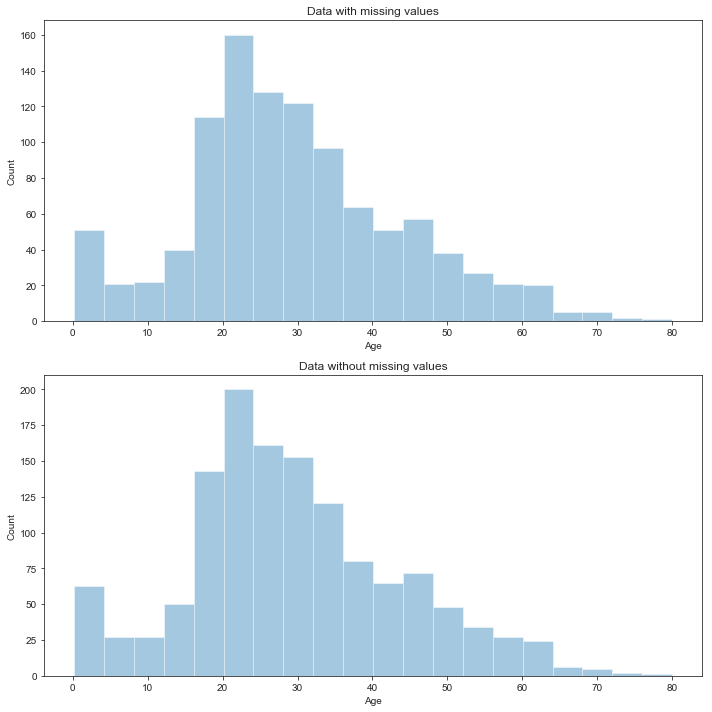

In [26]:
sns.set_style('ticks')
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(10,10))


sns.distplot(data['Age'],ax=ax1,bins=20,kde=False,)
ax1.set_title('Data with missing values')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')


sns.distplot(data_copy['Age'],ax=ax2,bins=20,kde=False)
ax2.set_title('Data without missing values')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')

plt.tight_layout()

<h3><b>Embarked</b></h3>

Column **'Embarked'** indicates the boarding places the passengers. it have only two missing values.
It will be filled by most reapted value **'S'**

In [27]:
data_copy['Embarked'].fillna(value='S',inplace=True)

<h3><b>Fare</b></h3>

Value of Fare is varies depending upon **Pclass** which is taken by passenger

In [28]:


data_copy[data_copy['Fare'].isna()]['Pclass']

PassengerId
1044    3
Name: Pclass, dtype: int64

In [29]:
Fare3class=data_copy[data_copy['Pclass']==3]['Fare'].mean()
data_copy['Fare'].fillna(value=Fare3class,inplace=True)

In [30]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Survived    891 non-null float64
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1309 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1309 non-null float64
Cabin       295 non-null object
Embarked    1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 162.7+ KB


##  Outlier detection

In [31]:
def Outlier_Detecter(data,feature):
    Q1=data[feature].quantile(0.25)
    Q3=data[feature].quantile(0.75)
    IQR=Q3-Q1
    Lower_lim=Q1-1.5*IQR
    Upper_lim=Q3+1.5*IQR
    return data[(data[feature] < Lower_lim ) & (data[feature] > Upper_lim)]

In [32]:
print(Outlier_Detecter(data_copy,'Age'))

Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


In [33]:
print(Outlier_Detecter(data_copy,'Fare'))

Empty DataFrame
Columns: [Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


> **There is no outliers present in the dataset**

##  Feature Creation

In [34]:
data_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
data_copy['Title']=data_copy['Name'].apply(lambda x:x.split()[1])

In [36]:
data_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.


## Categorical to Numerical

In [37]:
#Considering the important features that helps to predict the target variable 
#Pclass
#Sex
#Age
#SibSp
#Parch
#Fare
#Embarked
#Title

In [38]:
data_cn=data_copy[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked','Title']]

In [39]:
data_cn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,Mr.
2,1,female,38.0,1,0,71.2833,C,Mrs.
3,3,female,26.0,0,0,7.9250,S,Miss.
4,1,female,35.0,1,0,53.1000,S,Mrs.
5,3,male,35.0,0,0,8.0500,S,Mr.


### Sex

In [40]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data_cn['Sex']=le.fit_transform(data_cn['Sex'])

C:\Users\Nandhu\miniconda3\envs\study\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
data_cn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,1,22.0,1,0,7.2500,S,Mr.
2,1,0,38.0,1,0,71.2833,C,Mrs.
3,3,0,26.0,0,0,7.9250,S,Miss.
4,1,0,35.0,1,0,53.1000,S,Mrs.
5,3,1,35.0,0,0,8.0500,S,Mr.


### Embarked

In [42]:
from category_encoders import BinaryEncoder
bde=BinaryEncoder(cols='Embarked')
data_cn=bde.fit_transform(data_cn)

In [43]:

data_cn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Title
PassengerId,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0,1,Mr.
2,1,0,38.0,1,0,71.2833,0,1,0,Mrs.
3,3,0,26.0,0,0,7.9250,0,0,1,Miss.
4,1,0,35.0,1,0,53.1000,0,0,1,Mrs.
5,3,1,35.0,0,0,8.0500,0,0,1,Mr.


### Title

In [44]:
bde=BinaryEncoder(cols='Title')
data_cn=bde.fit_transform(data_cn)

In [45]:
data_cn.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6
PassengerId,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,1
2,1,0,38.0,1,0,71.2833,0,1,0,0,0,0,0,0,1,0
3,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,1,1
4,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,1,0
5,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,1


##  Train Test Split

In [46]:
# Training Data


train_cn=data_cn.loc[:891]

In [47]:
# Testing Data


test_cn=data_cn[891:].copy()

In [48]:
print('given train dataset shape:{}, \ngiven test dataset shape: {}'.format(train.shape,test.shape))

given train dataset shape:(891, 11), 
given test dataset shape: (418, 11)


In [49]:
print('preprocessed train dataset shape:{}, \npreprocessed test dataset shape: {}'.format(train_cn.shape,test_cn.shape))

preprocessed train dataset shape:(891, 16), 
preprocessed test dataset shape: (418, 16)


In [50]:
# Features

x_train=train_cn[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_0',
       'Embarked_1', 'Embarked_2', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
       'Title_4', 'Title_5', 'Title_6']]
x_test=test_cn[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_0',
       'Embarked_1', 'Embarked_2', 'Title_0', 'Title_1', 'Title_2', 'Title_3',
       'Title_4', 'Title_5', 'Title_6']]

In [53]:
# Target Variable

y_train=train['Survived']


In [54]:

x_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6
PassengerId,,,,,,,,,,,,,,,,
1,3,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,0,1
2,1,0,38.0,1,0,71.2833,0,1,0,0,0,0,0,0,1,0
3,3,0,26.0,0,0,7.9250,0,0,1,0,0,0,0,0,1,1
4,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,1,0
5,3,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,0,1


In [55]:
x_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_0,Embarked_1,Embarked_2,Title_0,Title_1,Title_2,Title_3,Title_4,Title_5,Title_6
PassengerId,,,,,,,,,,,,,,,,
892,3,1,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,0,1
893,3,0,47.0,1,0,7.0000,0,0,1,0,0,0,0,0,1,0
894,2,1,62.0,0,0,9.6875,0,1,1,0,0,0,0,0,0,1
895,3,1,27.0,0,0,8.6625,0,0,1,0,0,0,0,0,0,1
896,3,0,22.0,1,1,12.2875,0,0,1,0,0,0,0,0,1,0


In [56]:
y_train.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

## Importing Machine Learning algorithms and Metrics

In [57]:

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


## Logistic Regression Initial

In [58]:
def fLogR(Model,x_train,x_test,y_train):
   
    # Initializing the algorithm
    LR=LogisticRegression(max_iter=500)
    
    
    # Fitting the data into the algorithm
    lr=LR.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=lr.predict(x_test)
    
    
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_LR.csv')
    

## Random Forest Classifier

In [59]:
def fRF(Model,x_train,x_test,y_train):
    
    # Initializing the algorithm
    RF=RandomForestClassifier()

    
    # Fitting the data into the algorithm
    RF=RF.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=RF.predict(x_test)
    
    
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_RF.csv')
    

## Decision Tree Initial

In [60]:
def fDT(Model,x_train,x_test,y_train):

    # Initializing the algorithm
    DT=DecisionTreeClassifier()
    
    # Fitting the data into the algorithm
    DT=DT.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=DT.predict(x_test)
    
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_DT.csv')
        
    

## Naive Bayes Initial

In [61]:
def fNB(Model,x_train,x_test,y_train):
    
    
    # Initializing the algorithm
    NB=GaussianNB()
    
    # Fitting the data into the algorithm
    NB=NB.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=NB.predict(x_test)
    
    
       
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_NB.csv')
    

## K- Nearest Neighbors Initial

In [62]:
def fKNN(Model,x_train,x_test,y_train):
    

    # Initializing the algorithm
    KNN=KNeighborsClassifier()

    
    # Fitting the data into the algorithm
    KNN=KNN.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=KNN.predict(x_test)
    
    
    
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_KNN.csv')
    

##  XGBoost Initial

In [63]:
def fXGB(Model,x_train,x_test,y_train):
    
    
    # Initializing the algorithm
    XG=XGBClassifier()

    
    # Fitting the data into the algorithm
    XG=XG.fit(x_train,y_train)
    
    # Predicting the output for test dataset
    y_predict=XG.predict(x_test)
    
    
       
    # Saving the results in Csv
    data={'PassengerId':range(892,1310),'Survived':y_predict}
    pd.DataFrame(data).set_index('PassengerId').to_csv(r'submission files/submission_XGB.csv')
    

## Classification 

In [64]:
#Random Forest
fRF('Random Forest',x_train,x_test,y_train)

In [65]:
# Naive Bayes
fNB('Naive Bayes',x_train,x_test,y_train)

In [66]:
# Decision Tree
fDT('Decision tree',x_train,x_test,y_train)

In [67]:
# K nearest neighbors
fKNN('K-nearest Neighbors',x_train,x_test,y_train)

In [68]:
# Logistic Regression
fLogR('Logistic Regression',x_train,x_test,y_train)

In [69]:
# XGBoost
fXGB('XGBoost',x_train,x_test,y_train)